In [1]:
import comet_ml
from comet_ml.query import Parameter
import pandas as pd
import numpy as np

In [15]:
comet_api = comet_ml.api.API()
def get_query(t, opt):
    if opt =="SGDM":
        return Parameter(f'{t}_MOMENTUM') != None
    else:
        return Parameter(t) == opt
    
def get_exps(s):
    query = get_query('SERVER_OPT', s) & (Parameter('NORM') == 'group') & (Parameter('INIT') == 'keras')# & (Parameter('IMAGE_NORM') != 'tflike')
    return comet_api.query('federated-learning', 'server-side-opt-long', query)


In [16]:
def get_df(exps):
    def get_list(t, c):
        res = []
        for exp in exps:
            response = c(exp)
            if isinstance(response, list):
                res.append(None)
            else:
                res.append(t(response['valueMax']))
        return res
    
    def get_params(t, n):
        return get_list(t, lambda exp: exp.get_parameters_summary(n))
    def get_metrics(t, n):
        return get_list(t, lambda exp: exp.get_metrics_summary(n))
        
    ids = [exp.id for exp in exps]
    
    c_lr = get_params(float, 'CLIENT_LEARNING_RATE')
    s_lr = get_params(float, 'SERVER_LEARNING_RATE')
#     c_opt = get_params(str, 'CLIENT_OPT')
#     s_opt = get_params(str, 'SERVER_OPT')
#     c_momentum = get_params(str, 'CLIENT_OPT_MOMENTUM')
#     s_momentum = get_params(str, 'SERVER_OPT_MOMENTUM')
    
    last100_avg_acc = get_metrics(float, 'last100_avg_acc')
    teas = get_metrics(float, 'test_acc')
    return pd.DataFrame({'id': ids, 
                         'test_acc': teas, 
                         'c_lr': c_lr, 
                         's_lr': s_lr,
#                          'c_opt': c_opt,
#                          's_opt': s_opt,
#                          'c_momentum': c_momentum,
#                          's_momentum': s_momentum,
                        })

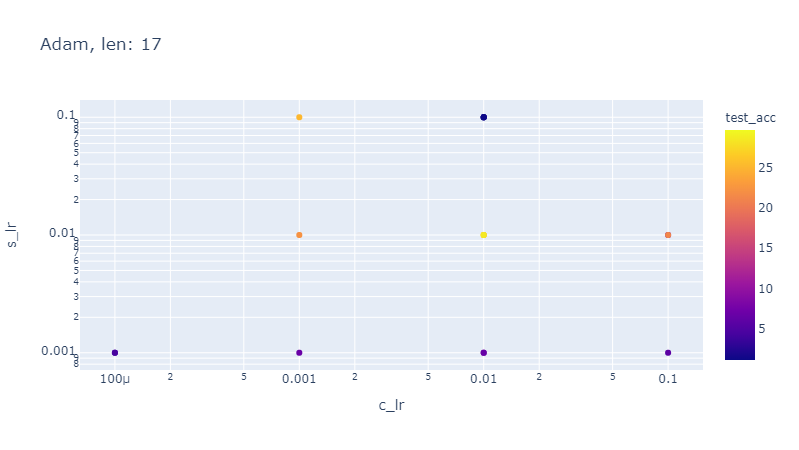

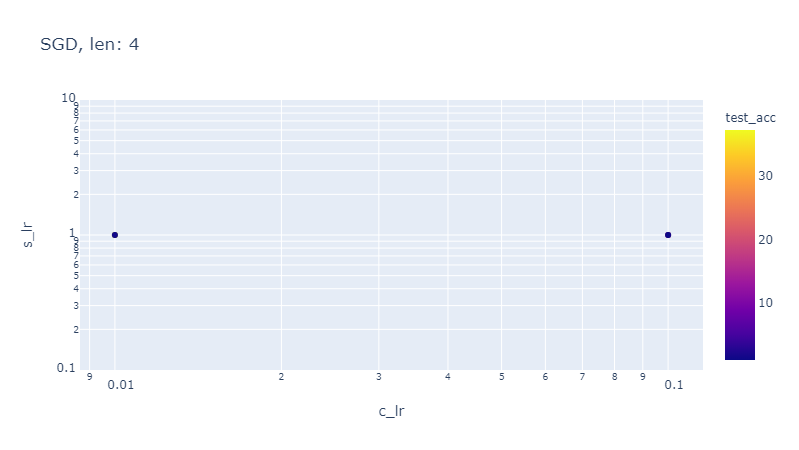

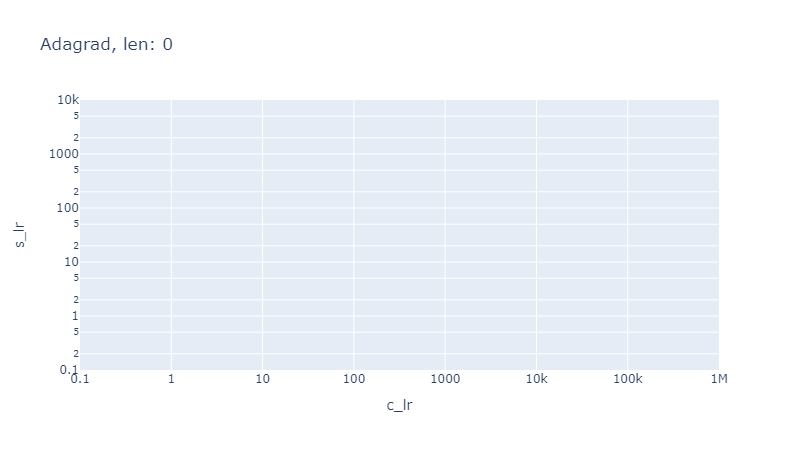

In [17]:
import plotly.graph_objects as go
import plotly.express as px

opts = ["Adam", "SGD", "Adagrad"]
for s in opts:
    exps = get_exps(s)
    df = get_df(exps)
    fig = px.scatter(df, x="c_lr", y="s_lr",
         color="test_acc", log_x=True, log_y=True, size_max=60, title=f'{s}, len: {len(exps)}')
    fig.show()